# Introduction

This notebook shows how to... 

* adjust the AGIPD geometry.
* save parameters using pickle.

# Imports and Function Definitions

**Packages To Load At the Beginning**

In [5]:
# lines starting with '%' are notebook magic functions
# %matplotlib notebook
%pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

# standard python packages
import numpy as np
import pandas as pd
import scipy.integrate as integrate
from scipy.stats import gamma as gammafunc
from scipy.special import gamma
from scipy.stats import norm

# main analysis software can be installed by: pip install Xana
from Xana import Xana
from Xana.Xplot.niceplot import niceplot

# reading AGIPD data provided by XFEL
from extra_data import RunDirectory, stack_detector_data
from extra_geom import AGIPD_1MGeometry

# for plotting
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set_context('notebook',)

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set the plot style with seaborn

## Helper Functions not Implemented in Xana, yet

In [6]:
# calculating analytical formfactor of spherical nanoparticles
def F_sphere(q,R): return 3.*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3

def schulzfunc(R,mR,z): return ((z+1)/mR)**(z+1) * R**z/gamma(z+1) * np.exp(-(z+1)*R/mR)

def I_saxs(q, R, sld=(1,0), **kwarg):
    norm = 1
    for name in kwarg:
        norm *= kwarg[name]
    if type(R) == list or type(R) == tuple:
        z = (100/R[1])**2 - 1
        V = np.array([integrate.quad(lambda x: schulzfunc(x,R[0],z) * (4/3*np.pi*(x*1e-9)**3)**2 * 
                                     abs(F_sphere(qi,x))**2, 0, np.inf)[0] for qi in q])
        return (abs(sld[0]-sld[1])*1e20)**2 * V * norm /100
    else:
        return (abs(sld[0]-sld[1])*1e20)**2 * (4/3*np.pi*(R*1e-9)**3) * abs(F_sphere(q,R))**2 * norm / 100

In [7]:
# shade ring on detector for manual calibration
def shade_wedges(ax, center, radii, alpha=0.6, cmap='inferno',):
    yl = ax.get_ylim()
    wedges = []
    r = radii
    nr = len(r)
        
    # Loop over data points; create box from errors at each point
    clrs = plt.get_cmap(cmap, nr)
    clrs = clrs(np.arange(nr))
    
    for ri in r:
        w = patches.Wedge(center, ri[0], 0, 360 , width=ri[1])
        wedges.append(w)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(wedges, facecolors=list(clrs), alpha=alpha,
                         edgecolor='k')

    # Add collection to axes
    lims = (ax.get_xlim(), ax.get_ylim())
    ax.add_collection(pc)
    ax.set_xlim(lims[0])
    ax.set_ylim(lims[1])
    
# add nice colorbar to plots
def add_colorbar(ax, im):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    colorbar(im, cax=cax)
    
# function to edit and display the AGIPD geometry in a simple way
def simple_geometry(image, quad_pos, ring_radius=None, ring_width=20, r=2000, vmin=None, vmax=None):
    
    if image.ndim == 4:
        image = image[0]
    
    geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=quad_pos)
    d, (cy,cx) = geom.position_modules_fast(image)
    img = d

    # plot only the center part of the detector with radius r [pixels]
    dim = img.shape
    x1, x2 = ( max( cx-r, 0 ), min( cx+r, dim[1] ) )
    y1, y2 = ( max( cy-r, 0 ), min( cy+r, dim[0] ) )
    
    fig, ax = plt.subplots(figsize=(8,9))
    ax = plt.gca()
    ax.hlines(cy-y1, cx-x1 - 20, cx-x1 + 20, colors='r', linewidths=1)
    ax.vlines(cx-x1, cy-y1 - 20, cy-y1 + 20, colors='r', linewidths=1)

    img = d
    im = ax.imshow(img, origin='lower', cmap='magma', norm=mpl.colors.LogNorm(vmin, vmax))
    add_colorbar(ax, im)

    # shade a ring in pixel coordinates for manual alignment
    if bool(ring_radius) and bool(ring_width):
        shade_wedges(ax, (cx-x1,cy-y1), [(ring_radius, ring_width)], alpha=.2)

    plt.tight_layout()

    dist = geom.to_distortion_array()
    
    return (cy,cx), dist, geom

# Select a Run

In [8]:
!ls /gpfs/exfel/exp/MID/202001/p002458/scratch/example_data # this is actually a shell command

r0390  r0522


In [9]:
run_id =  522 # define the run number

You can choose between *raw*  and *processed* data by choosing the corresponding folder.

In [10]:
rundir = f'/gpfs/exfel/exp/MID/202001/p002458/scratch/example_data/r{run_id:04d}/'
run = RunDirectory(rundir)
run.info()

# of trains:    1435
Duration:       0:02:23.5
First train ID: 541834019
Last train ID:  541835453

16 detector modules (MID_DET_AGIPD1M-1)
  e.g. module MID_DET_AGIPD1M-1 0 : 512 x 128 pixels
  MID_DET_AGIPD1M-1/DET/0CH0:xtdf
  100 frames per train, up to 143500 frames total

1 instrument sources (excluding detectors):
  - SA2_XTD1_XGM/XGM/DOOCS:output

13 control sources:
  - MID_DET_AGIPD1M/CC/MON_0
  - MID_EXP_AGIPD1M/GAUGE/PG1
  - MID_EXP_AGIPD1M/PSC/HV
  - MID_EXP_AGIPD1M/TSENS/H1_T_EXTHOUS
  - MID_EXP_AGIPD1M/TSENS/H2_T_EXTHOUS
  - MID_EXP_AGIPD1M/TSENS/Q1_T_BLOCK
  - MID_EXP_AGIPD1M/TSENS/Q2_T_BLOCK
  - MID_EXP_AGIPD1M/TSENS/Q3_T_BLOCK
  - MID_EXP_AGIPD1M/TSENS/Q4_T_BLOCK
  - MID_EXP_AGIPD1M1/CTRL/MC1
  - MID_EXP_AGIPD1M1/CTRL/MC2
  - MID_EXP_SYS/TSYS/UTC-2-S4
  - SA2_XTD1_XGM/XGM/DOOCS



# AGIPD Data

trains can be selected based on their train_id (unique, increasing number) 
or by their index (starting by 0 at the first train of a run).
The corresonding selection methods `train_from_id` or `train_from_index` 
can be used.

In [11]:
train_index = 5 # select the fivth train
tid, train_data = run.select('*/DET/*', 'image.data').train_from_index(train_index)

In [12]:
images = stack_detector_data(train_data, 'image.data') 
print(f'Shape of loaded data is {images.shape}')

Shape of loaded data is (100, 16, 512, 128)


We load the mask and invert it by using the "tilde". "good" pixels are 1 in the mask, bad ones 0.

In [13]:
mask = ~np.load('/gpfs/exfel/exp/MID/202001/p002458/scratch/masks/mask_cryo.npy') # load a mask

masked_pixels = sum(mask==0)/sum(mask==1) * 100
print(f"{masked_pixels:.2f}% of the pixels are masked.")

17.02% of the pixels are masked.


## Defining AGIPD Geometry

A simple way of calibrating the AGIPD, i.e., position the four quadrants correctly with respect to the direct beam, is to define the four corners of the quadrants. Their (x,y) coordinates are defined by a list of tubples, `quad_pos`. The `shade_wedges` function allows you to draw a ring with center (cx, cy) given the radius and the ring width. This makes it a little easier to see whether the quadrants are aligned properly. It has been built into `simple_geometry`.

If the relative distance of quadrants does not change but the detector position relative to the beam, use `dx` and `dy` to move all qaudrants.

By changing the parameter `r`, you can select the radius of the central section of the detector that is plotted.

`simple_geometry` returns the beam center, a distortion map, useful if you want to use pyFAI, and the `karabo_data` geometry.

In [14]:
avr_image = images.mean(0) # average all images of the train

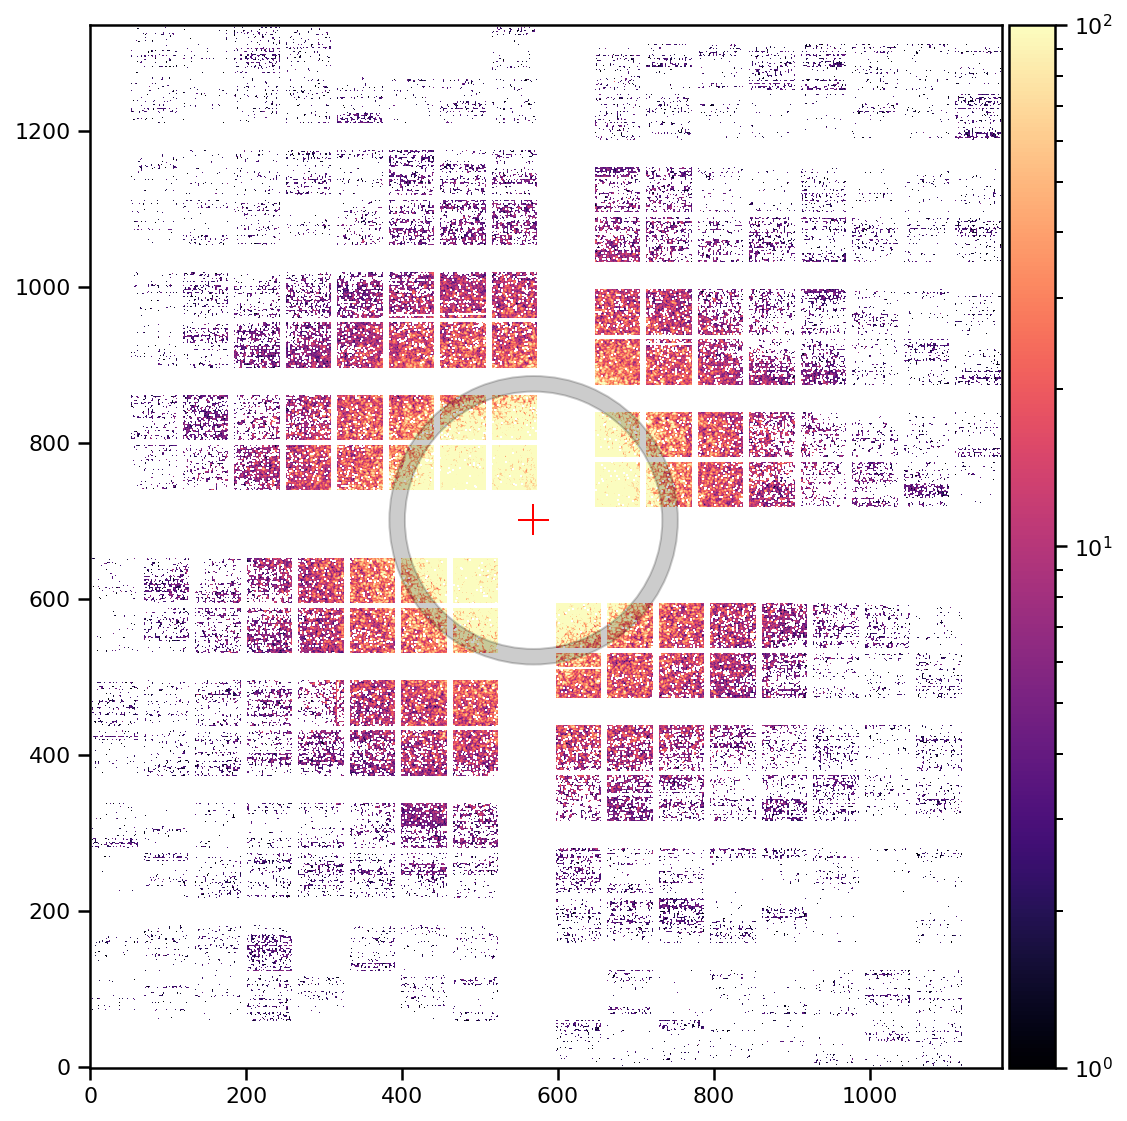

In [15]:
# define corners of quadrants. 
dx = -18
dy = -15
quad_pos = [(-500+dx, 650+dy),
           (-550+dx, -30+dy),
           (570+dx, -216+dy),
           (620+dx, 500+dy)] 

# ring radius and width for shaded area
ring_radius = 185
ring_width = 20

# section of detector to plot 
radial_section = 800


avr_image[mask==0] = np.nan
# use image and quad_pos for manual calibration
(cy,cx), dist, geom = simple_geometry(avr_image, quad_pos,
                                      ring_radius,
                                      ring_width,
                                      radial_section,
                                      vmin=1, vmax=100) # vmin and vmax can be set to modify the colorscale

## Define the Setup Parameters

In order to define your setup you need to know the sample-detector distance in meters and the wavelength of the x-rays in Angstrom. The beam center `ctr=(cy, cx)` is taken from your definition of the geometry (see above). Be a little careful with the way the center is defined. In the `karabo_data` geometry, the first coordinate is `y`, the second is `x`, but the setup class expects first `cx` and then `cy`.

Set the sample-detector distance in meters and the wavelength, too.

In [16]:
ENERGY = 8.8 # in keV
DISTANCE = 8 # in m

xana = Xana(detector='agipd1m', maskfile='')
xana.setup.make(distance=DISTANCE, center=(cx, cy), wavelength=12.38/ENERGY)
xana.setup.detector.set_pixel_corners(dist)
xana.setup.update_ai();

Mask file not found. Continuing with no pixel masked.


In [17]:
xana.mksavdir('./')
xana.savesetup('test')

Changing savdir to:
	/gpfs/exfel/data/user/reiserm/projects/proteins/mid-p2458/midtools/
Try loading database:
	/gpfs/exfel/data/user/reiserm/projects/proteins/mid-p2458/midtools/Analysis_db.pkl
	...loading database failed.
File exists. Save anyway? (No/Yes)	test
Result has not been saved.


# Save other parameters using pickle

In [19]:
import pickle

In [20]:
to_save = {
    'quad_pos':quad_pos
}
pickle.dump(to_save, open('./quad_pos.pkl', 'wb')) # the write binary mode (wb) flag is important

**Loading pickled dictionaries**

In [23]:
tmp = pickle.load(open('./quad_pos.pkl', 'rb')) # the read binary mode (rb) flag is important
print(tmp.keys())

quad_pos = tmp['quad_pos'] 

del tmp # delete the temporary dictionary 

quad_pos

dict_keys(['quad_pos'])


[(-518, 635), (-568, -45), (552, -231), (602, 485)]